In [6]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std
import numpy as np

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

import math
from scipy.ndimage import gaussian_filter

%matplotlib inline

20.0.0-4-gde602ef96+1


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{R}$')

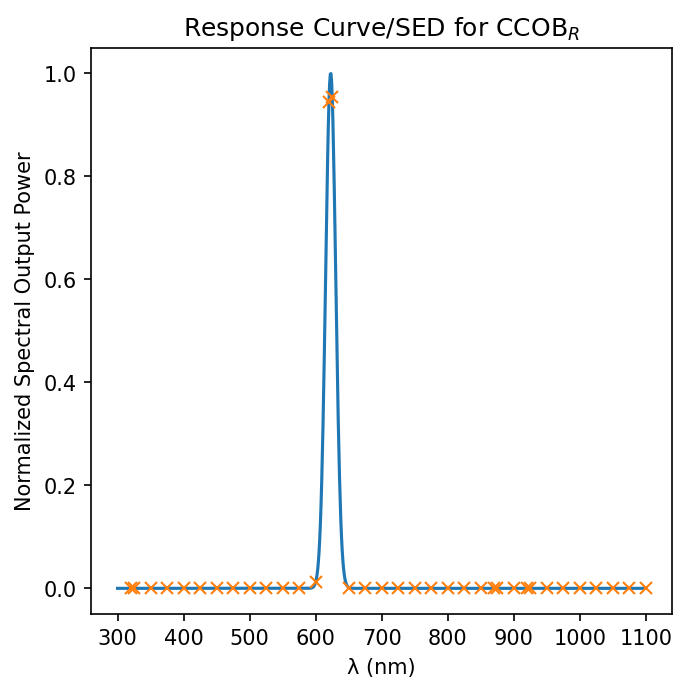

In [7]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
#print(wls)

# SED plot for red band
fig, axs = pylab.subplots(figsize=(5,5),dpi=150)

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)

mu = wavelengths_list[2]
sigma = width_of_wavelength_list_converted[2]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
# plots the gaussians
pylab.plot(x, y)

weights = numpy.interp(wls, x, y)   
# plots 'x's
pylab.plot(wls, weights,"x")

pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{R}$")

In [8]:
import numpy as np
import matplotlib.pyplot as plt

superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias


num_ch  = 16   
img_list_top_row = []
img_list_bottom_row = []
MEAN = None

for ch in range(num_ch):
    arr = []        
    for i, aqeflatpath in enumerate(qeflatpath):
        aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)
    
        img = aqeflat.unbiased_and_trimmed_image(ch + 1).getImage().array
        if MEAN is None:              # this will keep only one number for the normalization.
            MEAN = img.mean()
        img = img/img.mean()     # this will normalize your image

        arr.append(img*weights[i])
        arr.append(img*weights[i])
        
    img = numpy.sum(arr,axis=0)/numpy.sum(weights) 
    std = mad_std(img)
    N = 3
    
    if ch < num_ch / 2:
        img_list_top_row.append(img)
    else:
        img_list_bottom_row.append(img)
        
img_list_top_row.reverse()

In [9]:
### testing averaging 5 CCOB head positions
# fix, make cleaner into for loop

red_top = []
red_bot = []
normedimg_top = []
normedimg_bot = []

mean = None
num_ch  = 16
columns = 8
rows = 2

# loading all 5 position files
fname1= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-201.815_-10.575.fits"
fname2= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-201.815_9.785.fits"
fname3= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
fname4= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-221.815_-10.575.fits"
fname5= "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-221.815_9.785.fits"
file_list = [fname1, fname2, fname3, fname4, fname5]

# creating a list of the metadata arrays for each fname
ccob_list = []
for i in range(len(file_list)):
    ccob_red = get_ccd_from_id(None, file_list[i], [])
    ccob_list.append(ccob_red)

# looping over each amplifier in CCD
for ch in range(num_ch):
    
    # creating a list of the QE data arrays (at this amplifier) for each file
    ccob_position_list = []
    for i in range(5):
        red = get_data_as_read(ccob_list[i],ch + 1,["imaging"])["imaging"]   # use the list with metadata arrays here (ccob_list)
        ccob_position_list.append(red)
        
    # calculating the mean QE data array (at this amplifier) from all 5 files   
    ccob_sum = 0
    for ccob in ccob_position_list:
        ccob_sum += ccob
    red_avg = ccob_sum.mean()  
    
    if ch < columns:
        # calculating the mean of the QE data array (at this amplifier/channel) for the top row of amplifiers
        mean_sum = 0
        for i in range(5):
            mean_sum += get_data_as_read(ccob_list[i],columns-ch,["imaging"])["imaging"]
        mean = mean_sum.mean()  # used to normalize the amplifiers in the top row
        normedimg = img_list_top_row[ch]/img_list_top_row[ch].mean()*mean
        normedimg_top.append(normedimg)
        red_top.append(red_avg)
        
    else:
        mean = red_avg  # used to normalize the amplifiers in the bottom row
        normedimg = img_list_bottom_row[ch - columns]/img_list_bottom_row[ch - columns].mean()*mean
        normedimg_bot.append(normedimg)
        red_bot.append(red_avg)

red_top.reverse()
print(red_top)
print(red_bot)
print(normedimg_top)
print(normedimg_bot)

[329327.16, 329783.84, 330724.75, 330336.9, 330613.88, 330079.53, 330793.66, 330949.34]
[329531.16, 328355.72, 329972.1, 330362.7, 330039.6, 330258.97, 330354.53, 330774.25]
[array([[205327.92, 202209.  , 197319.4 , ..., 209718.39, 214687.61,
        220768.72],
       [244174.81, 244174.98, 246029.9 , ..., 260885.77, 261801.77,
        267028.44],
       [253359.05, 262752.53, 264993.56, ..., 277929.94, 281520.  ,
        276918.97],
       ...,
       [301326.28, 304846.66, 313969.66, ..., 327376.94, 329780.22,
        331942.94],
       [302408.38, 315706.66, 311666.5 , ..., 329425.3 , 325240.9 ,
        327914.8 ],
       [297369.22, 311874.62, 315600.72, ..., 327404.66, 326845.84,
        327613.7 ]], dtype=float32), array([[219780.12, 206243.27, 203266.89, ..., 211695.44, 216564.88,
        221231.9 ],
       [262101.88, 257612.25, 254842.89, ..., 261879.22, 259519.36,
        260921.33],
       [276700.62, 275106.9 , 274001.94, ..., 276684.03, 279214.22,
        279368.9 ],
    

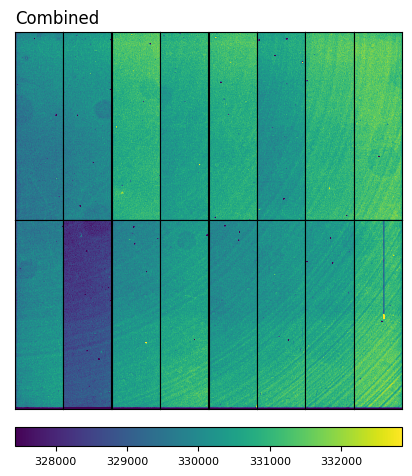

ValueError: operands could not be broadcast together with shapes (8,2000,509) (8,) 

<Figure size 500x500 with 0 Axes>

In [10]:
# GOAL: show full flats side-by-side, default color map: viridis for RED BAND

# normedimg flat (combined)

fig=plt.figure(figsize=(5, 5), dpi=100)   # dpi : dot per inch
columns = 8
rows = 2

wholepixels = numpy.array(normedimg_top + normedimg_bot).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(normedimg_top[i - 1])

    else:
        image = normedimg_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])   
    ax1.set_yticks([])
  
    N = 0.5
    
    if i == 1:
        plt.title("Combined", loc='left')
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()


"""
# CCOBr flat
fig=plt.figure(figsize=(5, 5), dpi=100)  
columns = 8
rows = 2

wholepixels = numpy.array(red_top + red_bot).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(red_top[i - 1])
    else:
        image = red_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])   
    ax1.set_yticks([])

    N = 0.5
    
    if i == 1:
        plt.title(r"CCOB$_{R}$", loc='left')
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()
"""

# ratio flat
fig=plt.figure(figsize=(5, 5), dpi=100)   
columns = 8
rows = 2

array = (numpy.array(normedimg_top) - numpy.array(red_top)) / numpy.array(red_top) + (numpy.array(normedimg_bot) - numpy.array(red_bot)) / numpy.array(red_bot)
wholepixels = numpy.array(array).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):                              
    if i < 9:
        image = np.flipud(((normedimg_top[i - 1]) - (red_top[i - 1])) / (red_top[i - 1]))
    else:
        image = ((normedimg_bot[i - 1 - columns]) - (red_bot[i - 1 - columns])) / (red_bot[i - 1 - columns])

    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    ax1.set_xticks([])   
    ax1.set_yticks([])
    if i == 1:
        plt.title("Ratio", loc='left')
        
    N = 0.5
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)   
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()